<a href="https://colab.research.google.com/github/MWSteams/WTPmodel_images/blob/master/TE_Filter_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TE Filter Model

Corrected to eliminate artificial dependencies on London Van der Waals forces that were created by including those forces in multiple dimensionless groups that canceled out.

Tufenkji, N. and M. Elimelech (2004). "Correlation equation for predicting single-collector efficiency in physicochemical filtration in saturated porous media."  [Environmental-Science-and-Technology 38(2): 529-536](https://doi.org/10.1021/es034049r).

# Clean Bed Filtration Model

The TE clean bed filtration model is based on Happel sphere-in-cell model of a single collector where the collector represents the sand grain. 

## Dimensionless groups

$$\Pi_R = \frac{d_p}{d_c}$$

$$\Pi_z = \frac{3 (1-\varepsilon)}{2  \ln (10)} \left(\frac{z}{d_c}\right)$$

$$\Pi_{Br} = \frac{k_b  T}{3  \pi  \mu  d_p  V_a  d_c}$$

$$\Pi_{{g}} = \frac{d_p^{2} \left(\rho_p-\rho_w\right)  g}{18  \mu  V_a}$$

## Porosity effects

$$\gamma:=(1-\varepsilon)^{\frac{1}{3}}$$

$$A_s:=\frac{2 \left(1-\gamma(\varepsilon)^{5}\right)}{2-3  \gamma(\varepsilon)+3  \gamma(\varepsilon)^{5}-2  \gamma(\varepsilon)^{6}}$$

## Transport by each mechanism

These equations have been modified to remove the artificial dependency introduced by TE. 

$$\eta_{Br} = \frac{3}{4}  {A}_s^{\frac{1}{3}}  {\Pi}_{R}^{-\frac{1}{6}}  {\Pi}_{Br}^{\frac{2}{3}}$$

$$\eta_R =\frac{1}{21.5}  {A}_s  \Pi_R^{1.425}$$

$$\eta_{g} = 0.31\Pi_g$$

$$\eta =\eta_{Br} +\eta_R +\eta_g $$

## Particle Removal

$${pC}_{Br} =\Pi_z  \alpha  \eta_{Br}$$

$${pC}_{{R}} ={\Pi}_{{z}}  \alpha  \eta_{{R}}$$

$${p} {C}_{{g}} ={\Pi}_{{z}}  \alpha  \eta_{{g}}$$

$${pC} ={\Pi}_{{z}} \alpha  \eta$$

The TE model includes Brownian motion, sedimentation, and interception. The model includes Van der Waals forces in multiple terms and an analysis of the exponents of those terms reveals that the Van der Waals forces are not a significant contribution to transport. This is as expected because Van der Waals are a potential attachment force and are too weak to be significant at the distances involved in particle transport.

The TE model reveals that particles that are larger than a few $\mu m$ are transported to the sand surfaces by a combination of gravity and interception in clean filters.

The TE model doesn't have the diameter of the constriction as parameter and thus is unable to model the effects of clogging. Perhaps porosity could be used to represent clogging, but that is a poor choice because the porosity of a full loaded filter is not significantly lower than the porosity of a clean filter because the volume of deposited particles is only a small fraction of the void volume.

In [0]:
!pip install aguaclara


In [0]:
import aguaclara as ac
from aguaclara.core.units import unit_registry as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
def logspace(start, stop, num=50):
  unit = start.units
  stop.ito(start.units)
  return np.logspace(np.log10(start.magnitude),np.log10(stop.magnitude),num) * unit

@ac.list_handler()
def p(x):
  return -np.log10(x)

D_sand = 0.5 * u.mm
v_a = 1.8 * u.mm/u.s
Temp = 20 * u.degC 
z = 20 * u.cm

alpha = 1
porosity = 0.4

# cube center to center distance for pores
@ac.list_handler()
def Lambda_pore(D_sand, porosity):
  return (np.pi/(6 * (1 - porosity)))**(1/3) * D_sand
  
@ac.list_handler()
def Q_pore(v_a,D_sand, porosity):
  return (v_a * (Lambda_pore(D_sand, porosity))**2).to(u.uL/u.s)

# constriction velocity taken from https://aguaclara.github.io/Textbook/Filtration/Filtration_Theory_and_Future_Work.html#equation-eq-he-filter2
v_constriction = 130 * u.mm/u.s
D_c = (ac.diam_circle(Q_pore(v_a,D_sand, porosity)/v_constriction)).to(u.um)
D_pore = 0.5 * D_sand
bacteria = ac.Material('bacteria', 1* u.um, 1005 * u.kg/u.m**3, None)
crypto = ac.Material('crypto', 4* u.um, 1005 * u.kg/u.m**3, None)
virus = ac.Material('crypto', 0.1* u.um, 1005 * u.kg/u.m**3, None)
nanoclay = ac.Material('nanoclay', 0.1* u.um, 2650 * u.kg/u.m**3, None)
clay = ac.Material('clay', 5* u.um, 2650 * u.kg/u.m**3, None)

In [0]:
@ac.list_handler()
def Pi_R(D_sand,D_p):
  return (D_p/D_sand).to(u.dimensionless)

@ac.list_handler()
def Pi_z(D_sand,z,porosity):
  return (z/D_sand * 3 * (1-porosity)/2/np.log(10)).to(u.dimensionless)

@ac.list_handler()
def Pi_Br(D_sand,D_p,v_a,Temp):
  return (u.boltzmann_constant*Temp/(3*np.pi*ac.viscosity_dynamic_water(Temp)*D_p*v_a*D_sand)).to(u.dimensionless)

@ac.list_handler()
def Pi_g(D_sand,D_p,v_a,Temp,DIM_FRACTAL,material):
  ConcAl = 0 * u.mg/u.L
  ConcClay = 1 * u.mg/u.L 
  coag = ac.PACl
  return (D_p**2 *(ac.dens_floc(ConcAl, ConcClay, DIM_FRACTAL, D_p, coag, material, Temp)-ac.density_water(Temp))*u.gravity/(18*ac.viscosity_dynamic_water(Temp)*v_a)).to(u.dimensionless)

@ac.list_handler()
def Re_p(D_sand,v_a,Temp):
  return (v_a * D_sand/ac.viscosity_kinematic_water(Temp)).to(u.dimensionless)

@ac.list_handler()
def A_s(porosity):
  x = (1-porosity)**(1/3)
  return 2 * (1-x**5)/(2-3*x + 3*x**5 - 2*x**6)

#Transport due to Brownian motion, gravity, and interception

@ac.list_handler()
def T_Br(D_sand,D_p,v_a,Temp,porosity):
  return 3/4 * A_s(porosity)**(1/3) * Pi_R(D_sand,D_p)**(-1/6) * Pi_Br(D_sand,D_p,v_a,Temp)**(2/3)

@ac.list_handler()
def T_In(D_sand,D_p,porosity):
  return 1/21.5 * A_s(porosity) * Pi_R(D_sand,D_p)**1.425

@ac.list_handler()
def T_g(D_sand,D_p,v_a,Temp,DIM_FRACTAL,material):
  return 0.31 * Pi_g(D_sand,D_p,v_a,Temp,DIM_FRACTAL,material)

@ac.list_handler()
def pC_Br(D_sand,D_p,v_a,z,Temp,porosity,alpha):
  return Pi_z(D_sand,z,porosity) * alpha * T_Br(D_sand,D_p,v_a,Temp,porosity)

@ac.list_handler()
def pC_In(D_sand,D_p,z,porosity,alpha):
  return Pi_z(D_sand,z,porosity) * alpha * T_In(D_sand,D_p,porosity)

@ac.list_handler()
def pC_g(D_sand,D_p,v_a,z,Temp,porosity,alpha,DIM_FRACTAL,material):
  return Pi_z(D_sand,z,porosity) * alpha * T_g(D_sand,D_p,v_a,Temp,DIM_FRACTAL,material)

@ac.list_handler()
def pC_T(D_sand,D_p,v_a,z,Temp,porosity,alpha, DIM_FRACTAL,material):
  return Pi_z(D_sand,z,porosity) * alpha * (T_Br(D_sand,D_p,v_a,Temp,porosity)+T_In(D_sand,D_p,porosity)+T_g(D_sand,D_p,v_a,Temp,DIM_FRACTAL,material))


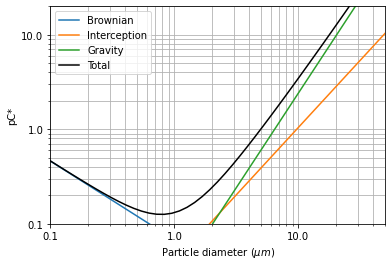

In [0]:
material = nanoclay
D_p_max = 100 * u.um
DIM_FRACTAL = 3
n = 50
D_p = logspace(material.Diameter,D_p_max,n) 
plt.plot(D_p,pC_Br(D_sand,D_p,v_a,z,Temp,porosity,alpha))
plt.plot(D_p,pC_In(D_sand,D_p,z,porosity,alpha))
plt.plot(D_p,pC_g(D_sand,D_p,v_a,z,Temp,porosity,alpha,DIM_FRACTAL,material))
plt.plot(D_p,pC_T(D_sand,D_p,v_a,z,Temp,porosity,alpha,DIM_FRACTAL,material),'k')
plt.xscale("log")
plt.yscale("log")
plt.legend(['Brownian','Interception','Gravity','Total'])
plt.ylim(ymin=0.1,ymax=20)
plt.xlim(xmin=0.1,xmax=50)
plt.grid(which='both',axis='both')
plt.ylabel('pC*')
plt.xlabel(r'Particle diameter ($\mu m$)')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.show()

For solid silica particles greater than about 1 $\mu m$ the dominant transport mechanism is sedimentation (see below).
![alt text](https://github.com/MWSteams/WTPmodel_images/raw/master/TE_silica_fractal3.png)

Figure 1. TE model with silica particles over a range of sizes all with a density of 2650 $\frac{kg}{m^3}$. The filter was 20 cm deep with 0.5 mm diameter sand and a filtration velocity of 1.8 mm/s and a water temperature of 20$^\circ$.

For solid organic particles (not fractals) greater than about 1 $\mu m$ the dominant transport mechanism is interception (see below).

![alt text](https://github.com/MWSteams/WTPmodel_images/raw/master/TE_organic_fractal3.png)

Figure 2. TE model with organic particles over a range of sizes all with a density of 1005 $\frac{kg}{m^3}$. The filter was 20 cm deep with 0.5 mm diameter sand and a filtration velocity of 1.8 mm/s and a water temperature of 20$^\circ$.

For fractal flocs (fractal dimension of 2.3) made of 5 $\mu m$ clay the dominant transport mechanism is gravity with interception also significant (see below). If the fractal dimension of the flocs is lower than 2.3 based on collisions of similar sized flocs in the flocculator, then the role of gravity is further reduced. 


![alt text](https://github.com/MWSteams/WTPmodel_images/raw/master/TE_silica_fractal23.png)

Figure 3. TE model with clay flocs over a range of sizes with a fractal dimension of 2.3. The filter was 20 cm deep with 0.5 mm diameter sand and a filtration velocity of 1.8 mm/s and a water temperature of 20$^\circ$.

The dominant transport mechanism for flocs that are less dense than clay flocs will be interception. Interception also will become more effective as the constrictions in the filter pores grow smaller. Thus interception is the dominant mechanisms for depth filters after the first layer of constrictions forms.

The next step is to create a filter model that can predict particle capture as particles are deposited in the pore constrictions and the constrictions become smaller. 






# Constricted Pore Model

## Nomenclature
$D_p$: diameter of particle

$D_{sand}$: diameter of sand grain

$D_c$:  diameter of constriction

$D_{c_{full}}$:  diameter of filled  constriction

$D_{c_{clean}}$:  diameter of clean constriction

$C_{pore}^\ast$ fraction of particles that remain after passing through a pore

The constricted pore model more closely approximates the constriction geometry from the perspective of the fluid than the collector model. The constriction geometry determines the volume of particles that can be captured by a pore. The fluid drag on particles that collide with the constriction determine whether those particles attach or are pushed deeper into the filter. The diameter of the constriction determines the head loss through the pore. The geometry of the constriction determines the fluid streamlines and the development of the boundary layer. A sharp edged constriction caused the boundary layer to begin at the sharp edge and thus the contraction approaches uniform velocity. The more gradual rounding of the sand grains that form the clean bed constriction have a fully developed boundary layer that results in a parabolic velocity profile. 

Particles are carried by the flow and intercept the constriction surface because the flow compression moves the particles closer to the wall. 

<img src="https://github.com/MWSteams/WTPmodel_images/raw/master/Constriction.png" alt="constriction" width="200"/>

Figure 4. Flow constriction showing constriction diameter and particle diameter.

The velocity profile has a substantial influence on the particle capture efficiency of a constriction. If the boundary layer is fully developed, then the flow through the annulus where particles collide with the wall is reduced due to the effects of viscosity. If the boundary layer hasn't begun to develop then the flow through the annulus of particle capture is much higher. We will first develop the equations for the simple case of no fluid boundary layer for a sharp constriction. If the velocity is uniform through the constriction then particles with their centers anywhere in the annulus will collide with the constriction.

## Uniform Velocity Profile

For the case of uniform velocity, the fraction of particles that escape capture through a pore is given by a ratio of the areas multipied by the attachment efficiency, $\alpha$.

![alt text](https://github.com/MWSteams/WTPmodel_images/raw/master/annulus.png) ![alt text](https://github.com/MWSteams/WTPmodel_images/raw/master/geometric_fraction_remaining.png) 

Figure 5. Particles with their center anywhere in the blue annulus will strike the wall of the constricion. The fraction of particles that pass through a single pore without colliding with the constriction wall is given by the ratio of the two areas. The failure to attach results in more of the particles in the purple ring passing through the constriction.

$$C_{pore}^{\ast_{U}} = \left( \frac{D_c - D_p}{D_c} \right)^2 + (1-\alpha)\left( 1-\left( \frac{D_c - D_p}{D_c} \right)^2 \right)$$

Simplify

$$C_{pore}^{\ast_{U}} = \left( \frac{D_c - D_p}{D_c} \right)^2 + \left( 1-\left( \frac{D_c - D_p}{D_c} \right)^2 \right) -\alpha\left( 1-\left( \frac{D_c - D_p}{D_c} \right)^2 \right)$$

More

$$C_{pore}^{\ast_{U}} = 1 -\alpha\left[ 1-\left( \frac{D_c - D_p}{D_c} \right)^2 \right]$$

Define a dimensionless parameter for the diameter ratio

$$\Pi_D  = \frac{D_p}{D_c}$$

Substitute in to get a dimensionless equation

$$C_{pore}^{\ast_{U}} = 1 -\alpha\left[ 1-\left( 1- \Pi_D \right)^2 \right]$$

$$C_{pore}^{\ast_{U}} = 1 -\alpha\left( 2\Pi_D - \Pi_D^2 \right)$$

$$C_{pore}^{\ast_{U}} = 1 - 2 \alpha \Pi_D + \alpha \Pi_D^2 $$

The fraction of particles that escape capture through n pores in series is simply


$$C_{filter}^{\ast_{U}} = \left( C_{pore}^{\ast_{U}}\right)^{n_{pore}}$$

We need a method to calculate the number of constrictions in a path through a filter. The number of pores is assumed to be the same as the number of sand grains. Thus the pore and sand spacing are equal: $\Lambda_{sand} = \Lambda_{pore}$. The sand grain is treated as a sphere and then the pore volume is added to the sphere volume to obtain the volume of the sand bed that is occupied by one pore. The spacing of the pores is then taken as the length of the side of the cube occupied by a grain of sand and its corresponding pore. The $\Lambda_{pore}^3$ is simply the volume occupied by a sand grain and its pore. The total volume is the sand volume divided by the sand fraction, $1-\phi$ where $\phi$ is the porosity or the pore fraction.

$$\Lambda_{pore}^3 = \left(\frac{1}{1-\phi} \right) \frac{\pi}{6}D_{sand}^3$$

$$\Lambda_{pore} = \left(\frac{\pi}{6(1-\phi)} \right)^\frac{1}{3}D_{sand}$$

The number of pores in the filter in a vertical path is

$$n_{pore} = \frac{z}{\Lambda_{pore}} $$

The fraction of influent particles that remain after passing through the entire filter is a simple calculation based on the constriction and particle diameters. If a particle size distribution is known and the constriction size is known for each pore, then the fraction of particles remaining could easily be calculated. 

## Fully Developed Boundary Layer

The flow rate for a pore is 

$$ Q_{pore} = v_a \Lambda_{pore}^2 $$ 

The area of a constriction can be calculated based on the head loss through a fully loaded filter. The head loss per pore can estimated from the number of pores in series. The clean bed head loss can be subtracted from the total head loss to obtain the head loss due to the constrictions. The constriction head loss is caused by a flow expansion and thus the flow expansion head loss equation can be used to determine the velocity in the contraction. 

$$ A_{constriction_{min}} = \frac{Q_{pore}}{v_{constriction}} $$

For a clean filter bed the flow through the constriction formed by sand grains is based on a parabolic velocity profile.

$$v=\frac{r^{2}-R^{2}}{4 \mu} \frac{d p}{d x}$$

We can eliminate the dependence on the pressure gradient by noting that the average velocity is 1/2 the maximum velocity for a parabolic velocity profile.

$$\bar v =-\frac{R^{2}}{8 \mu} \frac{d p}{d x}$$

Solve for $\frac{d p}{d x}$

$$ -\frac{8 \bar v \mu}{R^{2}} =\frac{d p}{d x}$$

Substitute into the equation for velocity as a function of r

$$ v = 2 \bar v \left(1-\frac{r^{2}}{R^{2}}\right) $$

Now we need to integrate $2\pi r v$ from $r = 0$ to $r = \frac{1}{2}(D_c-D_p)$ to obtain the flow rate through the center of the constriction carrying the particles that don't collide with the constriction surfaces, $\bar Q_{core}$.

$$ Q_{core} = 2 \pi \int_{0}^{\frac{1}{2}(D_c-D_p)}v  r dr $$

Substitute the equation for the velocity as a function of r.

$$ Q_{core} = 4 \bar v \pi \int_{0}^{\frac{1}{2}(D_c-D_p)} \left(1-\frac{r^{2}}{R^{2}}\right)r dr $$

Integrate.

$$ Q_{core} = 4 \bar v \pi \bigg\rvert_{0}^{\frac{1}{2}(D_c-D_p)} r^2\left( \frac{1}{2} - \frac{r^{2}}{4R^{2}}\right)  $$

Apply the limits of integration and substitue $R = \frac{D_c}{2}$.

$$ Q_{core} = 4 \bar v \pi  \left(\frac{1}{2}(D_c-D_p)\right)^2\left( \frac{1}{2} - \frac{\left(\frac{1}{2}(D_c-D_p)\right)^{2}}{4\left(\frac{D_c}{2}\right)^{2}}\right)  $$

$$ Q_{core} = \bar v \pi  \left((D_c-D_p)\right)^2\left( \frac{1}{2} - \frac{\left((D_c-D_p)\right)^{2}}{4D_c^{2}}\right)  $$

as before

$$ Q_{core} = \bar v \frac{\pi}{4} (D_c-D_p)^2\left[ 2 - \left(\frac{D_c-D_p}{D_c}\right)^{2}\right] $$

We want to know what fraction of the fluid that goes through a constriction ends up flowing through the core. The total flow through the constriction is

$$ Q_{c} = \bar v  \frac{\pi}{4}D_c^2 $$

Take the ratio of the core flow to the total constriction flow to obtain the fraction of the flow going through the central core.  

$$ \Pi_{Q_{core}}^{\ast_{BL}} =  \left(\frac{D_c-D_p}{D_c}\right)^{2} \left[ 2 - \left(\frac{D_c-D_p}{D_c}\right)^{2}\right] $$

Substitute the diameter ratio

$$ \Pi_{Q_{core}}^{\ast_{BL}} =  \left(1 - \Pi_D\right)^{2} \left[ 1 + 2\Pi_D - \Pi_D^2\right] $$

Multiply $1-\Pi_{Q_{core}}^{\ast_{BL}}$ by $1-\alpha$ to obtain the fraction of particles that weren't in the core flow that don't attach and then add that to the core flow to obtain the total fraction that pass through the pore.

$$C_{pore}^{\ast_{BL}} = \left(1-\Pi_{Q_{core}}^{\ast_{BL}}\right) \left(1-\alpha\right) + \Pi_{Q_{core}}^{\ast_{BL}}$$

When a particle attaches to the constriction it experiences a shear or drag force from the fluid and based on the new pore geometry. If the resulting force exceeds the bond strength, then the floc moves on and continues deeper into the filter. 

The pores in series are assumed to have complete mixing between pores. This redistribution of the particles is assumed to occur in transition between pores or in the flow expansion.

The fraction of particles that make it through a series of n pores in a filter is

$$ C_{filter}^{\ast_{BL}} = \left[\left(1-\Pi_{Q_{core}}^{\ast_{BL}}\right) \left(1-\alpha\right) + \Pi_{Q_{core}}^{\ast_{BL}}\right]^n $$



In [0]:
# number of constrictions the water flows through as it travels through length z of the sand bed
@ac.list_handler()
def N_constrictions(z, D_sand, porosity):
  return (z/Lambda_pore(D_sand, porosity)).to(u.dimensionless)

# fraction remaining after passing through a single pore with uniform velocity
@ac.list_handler()
def C_pore_uniform(D_c,D_p,porosity,alpha):
  return  1-alpha*(1-((D_c - D_p)/D_c)**2)
# ((D_c**2 - 2*alpha*D_p*D_c + alpha *D_p**2)/D_c**2)

# fraction remaining after passing through a filter with uniform velocity in the pores
@ac.list_handler()
def C_filter_uniform(D_sand,D_c,D_p,z,porosity,alpha):
  return C_pore_uniform(D_c,D_p,porosity,alpha)**N_constrictions(z,D_sand, porosity)

# ratio of flow through the core in boundary layer flow
@ac.list_handler()
def Ratio_core_bl(D_c,D_p):
  x = ((D_c - D_p)/D_c)**2
  return x * (2-x)

# fraction remaining after passing through a single pore with fully developed boundary layer
@ac.list_handler()
def C_pore_bl(D_sand,D_c,D_p,z,porosity,alpha):
  R = Ratio_core_bl(D_c,D_p)
  return (1-R)*(1-alpha) + R

# fraction remaining after passing through a filter with fully developed boundary layer in the pores
@ac.list_handler()
def C_filter_bl(D_sand,D_c,D_p,z,porosity,alpha):
  return (C_pore_bl(D_sand,D_c,D_p,z,porosity,alpha))**N_constrictions(z,D_sand, porosity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:1403: RuntimeWarning: divide by zero encountered in log10
  out = uf(*mobjs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:1403: RuntimeWarning: divide by zero encountered in log10
  out = uf(*mobjs)


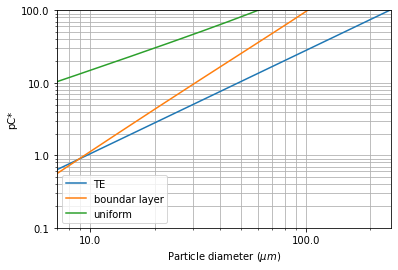

In [0]:
def plot_FM(D_sand,D_c,D_p,v_a,z,z_active,Temp,porosity,alpha,DIM_FRACTAL,material):
  plt.plot(D_p,pC_In(D_sand,D_p,z,porosity,alpha))
  plt.plot(D_p,p(C_filter_bl(D_sand,D_c,D_p,z_active,porosity,alpha)))
  plt.plot(D_p,p(C_filter_uniform(D_sand,D_c,D_p,z_active,porosity,alpha)))
  plt.xscale("log")
  plt.yscale("log")
  plt.legend(['TE','boundar layer','uniform'])
  plt.ylim(ymin=0.1,ymax=100)
  plt.xlim(xmin=material.Diameter.to(u.um).magnitude,xmax=D_c.to(u.um).magnitude)
  plt.grid(which='both',axis='both')
  plt.ylabel('pC*')
  plt.xlabel(r'Particle diameter ($\mu m$)')
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
  plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
  plt.show()


D_p_max = D_pore
n = 500
D_p = logspace(material.Diameter,D_p_max,n) 
z_active = z
# Lambda_pore(D_sand, porosity) * 10

plot_FM(D_sand,D_pore,D_p,v_a,z,z_active,Temp,porosity,alpha,2.3,ac.Clay)

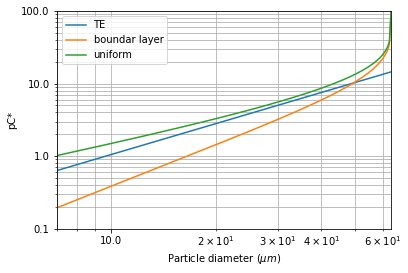

In [0]:
z_active = Lambda_pore(D_sand, porosity) * 10
alpha = 1
D_p = logspace(material.Diameter,D_c*0.999999,n) 
plot_FM(D_sand,D_c,D_p,v_a,z,z_active,Temp,porosity,alpha,2.3,ac.Clay)

# Comparison of the three interception models

For a clean bed the boundary layer is expected to be fully developed at each constriction. The TE model and the fully developed boundary layer constriction models provide identifical predictions for clay particles. The constriction model predicts higher removal efficiency than the TE model for flocs of larger diameter. This is likely because the TE model didn't account for the constriction diameter. 

The uniform velocity model predicts extremely efficent particle capture because the velocity near the sand grain surfaces is equal to the average velocity and the effects of viscosity are neglected.

![alt text](https://github.com/MWSteams/WTPmodel_images/raw/master/Interception_clean_bed.png)

Figure 6. Clean bed filtration with the constriction size set to 0.5 of the sand diameter.

The constrictions 

In [0]:
y_C_bl = (C_filter_bl(D_sand,D_c,0.001*D_c,z_active,porosity,alpha))
y_C_uniform = (C_filter_uniform(D_sand,D_c,0.001*D_c,z_active,porosity,alpha))

print(y_C_bl/y_C_uniform)
print(y_C_uniform)

1.02 dimensionless
0.9802 dimensionless


In [0]:
ConcAl = 0 * u.mg/u.L
ConcClay = 50 * u.NTU
DIM_FRACTAL = 2.3
D_p = 0.5 * u.mm
coag = ac.PACl
material = ac.Clay
temp = 20 * u.degC
Floc_density = ac.dens_floc(ConcAl, ConcClay, DIM_FRACTAL, D_p, coag, material, Temp)
print(Floc_density.magnitude)
Fg = ((Floc_density - ac.density_water(temp))*u.gravity * D_p**3 * np.pi/6).to(u.nN)
print('The force is',Fg)

1081.423712798733
The force is 53.42 nanonewton


# Drag on a clay particle

The drag on one side of a flat plate under conditions of laminar flow is
$$F_{d}=0.664 w \sqrt{\mu \rho U^{3} l}$$

We can approximate drag on a round plate (very rough estimate) as

$$F_{d}=0.664 \sqrt{\mu \rho (vd)^{3}}$$

This analysis suggests a chemical bond strength that is order 0.5 nN.


In [0]:
F_drag_clay = (0.664 * np.sqrt(ac.viscosity_dynamic_water(temp) * ac.density_water(temp)*(v_constriction * ac.Clay.Diameter)**(3))).to(u.nN)
print(F_drag_clay)

0.5764 nanonewton


#References
Tufenkji, N. and M. Elimelech (2004). "Correlation equation for predicting single-collector efficiency in physicochemical filtration in saturated porous media." Environmental-Science-and-Technology 38(2): 529-536.

In [0]:
EnergyDis = 10 * u.mW/u.kg
Temp = 20*u.degC
Time = 8 * u.min
DiamTube = 10 * u.inch
ConcClay = 100 * u.NTU
ConcAl = 1.2 * u.mg/u.L
ConcNatOrgMat = 15 * u.mg/u.L
NatOrgMat = ac.HumicAcid
coag = ac.PACl
material = ac.Clay
FittingParam = 0.05
RatioHeightDiameter = 0.2



x = ac.pc_viscous(EnergyDis, Temp, Time, DiamTube, ConcClay, ConcAl, ConcNatOrgMat, NatOrgMat, coag, material, FittingParam, RatioHeightDiameter)
print(x)

0.4957 dimensionless


In [0]:
print(ac.p(0.01))

2.0
